In [1]:
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import combinations



random.seed(30)
df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [2]:
# Convert 'Quarter' to a sequential numeric value based on time order
df['Year'] = df['Quarter'].str.extract(r'(\d{4})').astype(int)
df['Quarter_Num'] = df['Quarter'].str.extract(r'(Q\d)').replace({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}).astype(int)
df['Quarter_order'] = (df['Year'] - df['Year'].min()) * 4 + (df['Quarter_Num'] - 1)
df

C:\Users\FKP0\AppData\Local\Temp\ipykernel_25036\577555509.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Quarter_Num'] = df['Quarter'].str.extract(r'(Q\d)').replace({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}).astype(int)


,Quarter,Consumption,Income,Production,Savings,Unemployment,Year,Quarter_Num,Quarter_order
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9,1970,1,0
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5,1970,2,1
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5,1970,3,2
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7,1970,4,3
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1,1971,1,4
...,...,...,...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0,2018,2,193
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3,2018,3,194
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2,2018,4,195
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1,2019,1,196


In [3]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


def prepare_data_for_regression(df, target_column, covariates, test_size=40):
    """
    Função para dividir os dados entre treino e teste.
    """
    X = df[covariates]
    y = df[target_column]
    X_train, X_test = X[:-test_size], X[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]
    return X_train, X_test, y_train, y_test

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Função para calcular o MASE (Mean Absolute Scaled Error).
    """
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para o erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

df['Quarter'] = df['Quarter'].apply(lambda x: x.to_timestamp())
df.set_index("Quarter", inplace=True)


In [5]:
from itertools import combinations

# Function to test different combinations of covariates and return the best performing set
def find_best_covariates(df, target_column, covariates, test_size=40):
    best_mae = float('inf')
    best_rmse = float('inf')
    best_mase = float('inf')
    best_covariates = []

    results = []  # Store results for each combination

    # Iterate over all combinations of covariates
    for r in range(1, len(covariates) + 1):
        for subset in combinations(covariates, r):
            subset = list(subset)

            # Prepare data with the current subset of covariates
            X_train, X_test, y_train, y_test = prepare_data_for_regression(df, target_column, subset, test_size)

            # Train the model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mase = mean_absolute_scaled_error(y_test, y_pred, y_train)

            # Store results
            results.append({
                'Covariates': subset,
                'MAE': mae,
                'RMSE': rmse,
                'MASE': mase
            })

            # Update best result if current subset performs better
            if mase < best_mase:
                best_mae = mae
                best_rmse = rmse
                best_mase = mase
                best_covariates = subset

    # Convert results to a DataFrame for easy viewing and sorting
    results_df = pd.DataFrame(results).sort_values(by='MASE').reset_index(drop=True)
    return best_covariates, best_mae, best_rmse, best_mase, results_df

# Execute function to find the best covariates set
covariates = ["Income", "Production", "Savings", 'Unemployment', 'Quarter_order']
best_covariates, best_mae, best_rmse, best_mase, results_df = find_best_covariates(df, target_column="Consumption", covariates=covariates)


best_covariates, best_mae, best_rmse, best_mase

(['Income', 'Savings', 'Quarter_order'],
 np.float64(0.09806759679801196),
 np.float64(0.15254341013745007),
 np.float64(0.16042087529954585))

In [6]:

def fit_and_plot_regression(df, target_column, covariates):
    """
    Função para ajustar um modelo de regressão linear múltipla e plotar as previsões.
    """
    X_train, X_test, y_train, y_test = prepare_data_for_regression(df, target_column, covariates)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train)
    
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MASE: {mase}")
    

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[target_column], label="True Values", color="blue")
    plt.plot(df.index[-len(y_test):], y_pred, label="Predictions", color="red")
    plt.xlabel("Time")
    plt.ylabel(target_column)
    plt.title("Multiple Linear Regression Predictions")
    plt.legend()
    plt.show()


Primeiro, vamos testar com todas as covariáveis, sem nenhuma transformação aplicada.

MAE: 0.115131447639742
RMSE: 0.14961786029073468
MASE: 0.18833425318775282


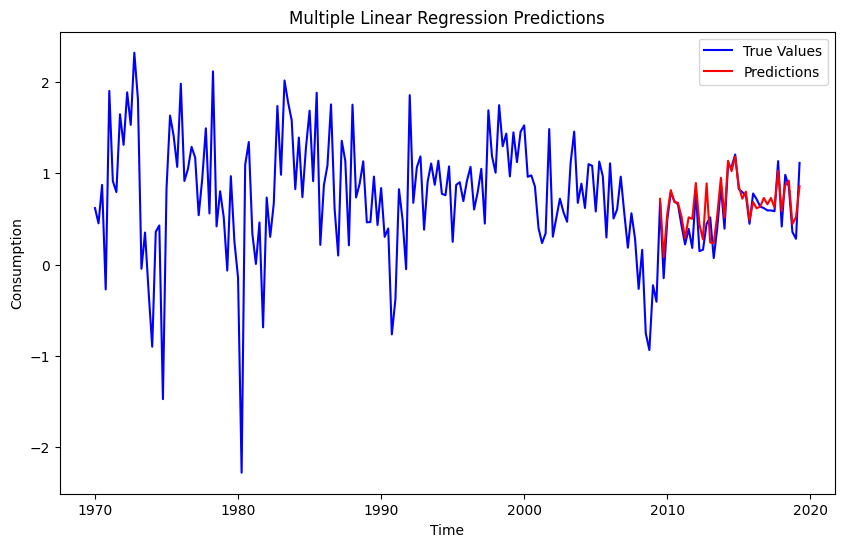

In [10]:
covariates = ["Income", "Production", "Savings", 'Unemployment', 'Quarter_order']

fit_and_plot_regression(df, target_column="Consumption", covariates=covariates)

Agora, selecionaremos as variáveis com melhor métrica ajustada.

MAE: 0.09806759679801196
RMSE: 0.15254341013745007
MASE: 0.16042087529954585


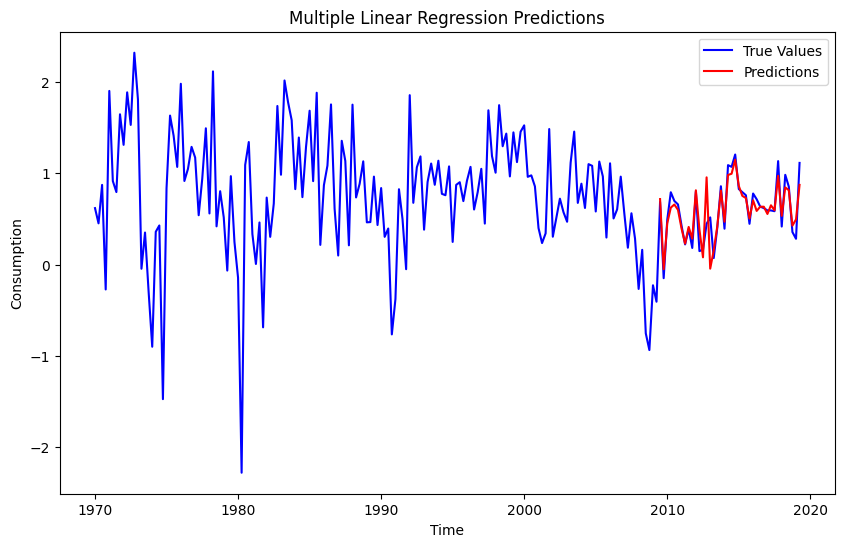

In [8]:
covariates = ["Income", "Savings", 'Quarter_order']

fit_and_plot_regression(df, target_column="Consumption", covariates=covariates)